# Statistical Analysis of Market Returns
This project investigates the normality of financial returns using statistical tests like the Jarque-Bera test. Focusing on various market indices, including CRSP SmallCap and LargeCap, it identifies deviations from a normal distribution. The findings aim to enhance investment strategies and risk management by providing a deeper understanding of market return behaviors.

## Foundations of Risk and Performance Analysis
In this first section, I dive into the fundamental risk and performance indicators critical to portfolio management. I start by demystifying volatility as the primary measure of risk. Then, I delve into the significance and persistence of risks in non-normal return distributions, highlighting the importance of understanding higher-order moments for strategic asset allocation.

I also introduce more nuanced risk metrics like Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR), crucial for handling assets with non-standard returns. This part is about laying the essential groundwork for navigating portfolio risks and enhancing performance with a keen eye on the intricacies of asset behavior.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
#import seaborn as sns
#from datetime import datetime
# Add any other libraries you anticipate needing

### Risk Adjusted Returns

Let's start working with some real data. I read in the monthly returns of a set of 10 portfolios formed on market caps, or market equities of the companies. Of the 10 portfolios, I would look at the largest cap and the smallest cap companies:

In [4]:
me_m = pd.read_csv("Data/Portfolios_Formed_on_ME.csv",
                   header=0, index_col=0, parse_dates=True, na_values=-99.99)
me_m.head()

/var/folders/g8/p_3zs4gn64vc1d40qp2p3s700000gp/T/ipykernel_61517/2805160278.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  me_m = pd.read_csv("Data/Portfolios_Formed_on_ME.csv",


,<= 0,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec.02,Dec.03,Dec.04,Dec.05,Dec.06,Dec.07,Dec.08,Dec.09,Hi 10
192607,NaN,-0.43,1.45,2.68,-0.57,0.37,1.65,1.50,3.33,-1.42,0.29,-0.15,0.88,1.45,1.85,1.63,1.38,3.38,3.29
192608,NaN,3.74,3.03,2.09,3.60,3.64,3.66,1.58,2.33,4.61,2.59,4.03,3.24,2.66,4.67,1.54,1.63,0.98,3.70
192609,NaN,-1.07,-0.59,0.16,-0.48,-1.55,0.03,-0.47,-0.09,0.91,-1.87,-2.27,-0.84,0.12,-0.07,-1.58,0.64,-0.86,0.67
192610,NaN,-3.29,-3.56,-3.06,-3.25,-4.18,-2.90,-3.36,-2.95,-4.72,-1.77,-3.36,-5.01,-3.09,-2.71,-3.45,-3.27,-3.47,-2.43
192611,NaN,-0.46,3.83,3.09,-0.54,2.25,3.37,3.37,3.16,-0.77,-0.32,-0.29,4.79,3.17,3.58,3.80,2.95,3.61,2.70


In [5]:
cols = ['Lo 10', 'Hi 10']
returns = me_m[cols]
returns.head()

,Lo 10,Hi 10
192607,-1.42,3.29
192608,4.61,3.70
192609,0.91,0.67
192610,-4.72,-2.43
192611,-0.77,2.70


Note that the data is already given in percentages (i.e 4.5 instead of 0.045) and we typically want to use the actual numbers (i.e. 0.045 instead of 4.5) so we should divide the raw data from the file by 100.

In [6]:
returns = returns/100

<Axes: >

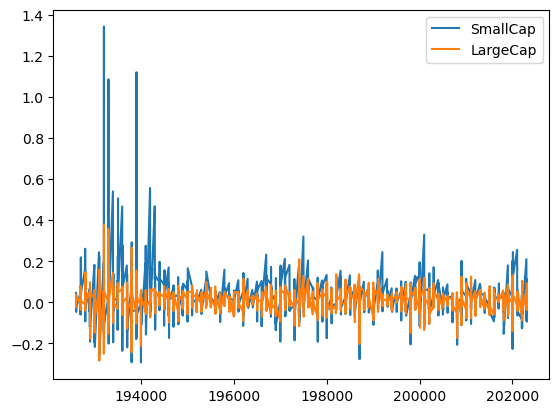

In [7]:
returns.columns = ['SmallCap', 'LargeCap']
returns.plot()

In [8]:
annualized_vol = returns.std()*np.sqrt(12)
annualized_vol

SmallCap    0.364525
LargeCap    0.186647
dtype: float64

In [9]:
n_months = returns.shape[0]
return_per_month = (returns+1).prod()**(1/n_months) - 1
return_per_month

SmallCap    0.012642
LargeCap    0.007589
dtype: float64

In [10]:
annualized_return = (return_per_month + 1)**12-1
annualized_return

SmallCap    0.162705
LargeCap    0.094961
dtype: float64

In [11]:
riskfree_rate = 0.03
excess_return = annualized_return - riskfree_rate
sharpe_ratio = excess_return/annualized_vol
sharpe_ratio

SmallCap    0.364050
LargeCap    0.348044
dtype: float64

### Computing Maximum Drawdown

In this, I'll develop the code to compute the maximum drawdown of a return series.

First, I read the return series:

/var/folders/g8/p_3zs4gn64vc1d40qp2p3s700000gp/T/ipykernel_61517/1285115287.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  me_m = pd.read_csv("Data/Portfolios_Formed_on_ME.csv",


<Axes: >

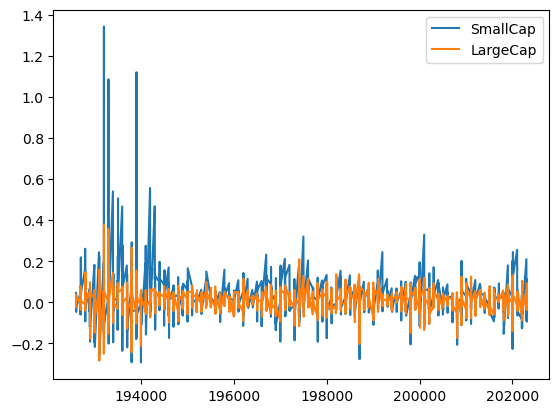

In [12]:
import pandas as pd

me_m = pd.read_csv("Data/Portfolios_Formed_on_ME.csv",
                   header=0, index_col=0, parse_dates=True, na_values=-99.99)
rets = me_m[['Lo 10', 'Hi 10']]
rets.columns = ['SmallCap', 'LargeCap']
rets = rets/100
rets.plot.line()

In [13]:
rets.index = pd.to_datetime(rets.index, format="%Y%m")
rets.index

DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', length=1170, freq=None)

In [20]:
rets.loc["2008"]

,SmallCap,LargeCap
2008-01-01,-0.0436,-0.0493
2008-02-01,-0.0200,-0.0259
2008-03-01,-0.0439,-0.0130
2008-04-01,0.0040,0.0488
2008-05-01,0.0285,0.0156
2008-06-01,-0.0825,-0.1020
2008-07-01,-0.0085,-0.0099
2008-08-01,0.0104,0.0092
2008-09-01,-0.1295,-0.1131
2008-10-01,-0.2074,-0.1741


In [21]:
rets.index = rets.index.to_period('M')
rets.head()

,SmallCap,LargeCap
1926-07,-0.0142,0.0329
1926-08,0.0461,0.0370
1926-09,0.0091,0.0067
1926-10,-0.0472,-0.0243
1926-11,-0.0077,0.0270


In [22]:
rets.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1170 entries, 1926-07 to 2023-12
Freq: M
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SmallCap  1170 non-null   float64
 1   LargeCap  1170 non-null   float64
dtypes: float64(2)
memory usage: 27.4 KB


In [23]:
rets.describe()

,SmallCap,LargeCap
count,1170.000000,1170.000000
mean,0.017194,0.009034
std,0.105229,0.053880
min,-0.293200,-0.284300
25%,-0.028075,-0.017275
50%,0.010500,0.011600
75%,0.049375,0.038500
max,1.342100,0.377900


## Drawdown function

In [33]:
def calculate_drawdown(return_series: pd.Series) -> pd.DataFrame:
    """
    Calculates the drawdown of a financial asset given a time series of returns.

    Parameters:
    - return_series (pd.Series): A time series of asset returns.

    Returns:
    - pd.DataFrame: A DataFrame with columns for the wealth index, the previous peaks,
                    and the percentage drawdown.

    Raises:
    - ValueError: If the input is not a pandas Series.
    """
    if not isinstance(return_series, pd.Series):
        raise ValueError("Input must be a pandas Series.")

    # Calculate wealth index from a $1000 initial investment
    wealth_index = 1000 * (1 + return_series).cumprod()

    # Determine the previous peaks of the wealth index
    previous_peaks = wealth_index.cummax()

    # Calculate drawdowns as the percentage difference from previous peaks
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    # Compile wealth index, previous peaks, and drawdowns into a DataFrame
    results = pd.DataFrame({
        "Wealth": wealth_index,
        "Previous Peak": previous_peaks,
        "Drawdown": drawdowns
    })

    return results

In [29]:
calculate_drawdown(rets["LargeCap"]).head()

,Wealth,Previous Peak,Drawdown
1926-07,1032.900000,1032.900000,0.0000
1926-08,1071.117300,1071.117300,0.0000
1926-09,1078.293786,1078.293786,0.0000
1926-10,1052.091247,1078.293786,-0.0243
1926-11,1080.497711,1080.497711,0.0000


In [31]:
calculate_drawdown(rets["LargeCap"]).min()

Wealth            405.769102
Previous Peak    1032.900000
Drawdown           -0.840038
dtype: float64

In [33]:
calculate_drawdown(rets["SmallCap"]).min()

Wealth           460.436683
Previous Peak    985.800000
Drawdown          -0.837451
dtype: float64

In [34]:
calculate_drawdown(rets["LargeCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [35]:
calculate_drawdown(rets["SmallCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [36]:
calculate_drawdown(rets["LargeCap"]["1975":])["Drawdown"].idxmin()

Period('2009-02', 'M')

In [37]:
calculate_drawdown(rets["SmallCap"]["1975":])["Drawdown"].idxmin()

Period('2009-02', 'M')

In [38]:
calculate_drawdown(rets["SmallCap"]["1975":])["Drawdown"].min()

-0.6368665082051987

In [41]:
df_drawdown = calculate_drawdown(rets["SmallCap"]["1975":])

<Axes: >

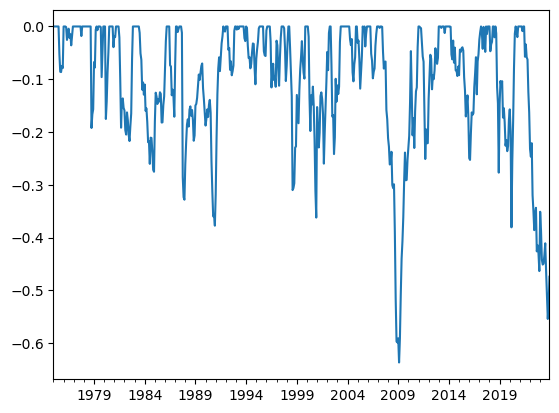

In [42]:
df_drawdown['Drawdown'].plot()

## Deviations from Normality



This dataset in the next function presents monthly performance data in percentages for various hedge fund strategies, addressing the challenge of benchmarking in the hedge fund sector due to its diverse and opaque nature. It aligns with the EDHEC-Risk Alternative Indices, covering thirteen investment styles to provide a comprehensive benchmark. The aim is to offer investors a clearer performance comparison tool across different hedge fund strategies.

In [122]:
def get_hfi_returns(filepath="data/edhec-hedgefundindices.csv"):
    """
    Load and format the EDHEC Hedge Fund Index Returns.

    Parameters:
    - filepath: str, the path to the CSV file containing the hedge fund indices data.

    Returns:
    - hfi: DataFrame, the formatted hedge fund indices with dates as a PeriodIndex.
    """
    try:
        # Load the CSV file, automatically parse dates, and set the first column as the index
        hfi = pd.read_csv(filepath, sep=';', index_col='date', parse_dates=True, dayfirst=True)
        # Convert percentage strings to floats and divide by 100
        hfi = hfi.apply(lambda x: x.str.rstrip('%').astype('float') / 100 if x.dtype == 'object' else x)
        # Convert the index to a monthly period
        hfi.index = hfi.index.to_period('M')
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    return hfi

In [123]:
hfi = get_hfi_returns()
hfi.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
1997-01,0.0119,0.0393,0.0178,0.0791,0.0189,0.0213,0.0191,0.0573,0.0281,0.0150,0.0180,-0.0166,0.0317
1997-02,0.0123,0.0298,0.0122,0.0525,0.0101,0.0084,0.0122,0.0175,-0.0006,0.0034,0.0118,0.0426,0.0106
1997-03,0.0078,-0.0021,-0.0012,-0.0120,0.0016,-0.0023,0.0109,-0.0119,-0.0084,0.0060,0.0010,0.0778,-0.0077
1997-04,0.0086,-0.0170,0.0030,0.0119,0.0119,-0.0005,0.0130,0.0172,0.0084,-0.0001,0.0122,-0.0129,0.0009
1997-05,0.0156,-0.0015,0.0233,0.0315,0.0189,0.0346,0.0118,0.0108,0.0394,0.0197,0.0173,-0.0737,0.0275


## Skewness

A negative skew indicates a higher frequency of negative returns than expected under a normal distribution.

Typically, in a normal distribution, the mean and median are similar. With negative skewness, the mean (expected value) is lower than the median, whereas it's higher in the case of positive skewness.

In [100]:
pd.concat([hfi.mean(), hfi.median(), hfi.mean()>hfi.median()], axis=1)

,0,1,2
Convertible Arbitrage,0.005781,0.00650,False
CTA Global,0.004284,0.00190,True
Distressed Securities,0.006837,0.00880,False
Emerging Markets,0.006740,0.00985,False
Equity Market Neutral,0.004330,0.00465,False
Event Driven,0.006660,0.00875,False
Fixed Income Arbitrage,0.004404,0.00550,False
Global Macro,0.005539,0.00465,True
Long/Short Equity,0.006700,0.00815,False
Merger Arbitrage,0.005569,0.00590,False


The skewness is given by:

$$ S(R) = \frac{E[ (R-E(R))^3 ]}{\sigma_R^3} $$


In [124]:
def skewness(r):
    """
    Computes the skewness of the supplied pandas Series or DataFrame along each column.
    
    This is an alternative to scipy.stats.skew() specifically designed for pandas data structures.
    It uses the population standard deviation (degrees of freedom = 0) for its calculation.
    
    Parameters:
    - r: pandas Series or DataFrame. The data for which skewness is to be computed.
    
    Returns:
    - A float or a pandas Series representing the skewness of the input. For a Series input,
      a single float value is returned. For a DataFrame, a Series is returned with the skewness
      value for each column.
    
    Notes:
    - This function returns NaN for columns where the standard deviation is zero,
      indicating that skewness is undefined in such scenarios.
    """
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    
    # Prevent division by zero by returning NaN if sigma_r is 0
    if (sigma_r == 0).any():
        return float('nan') if isinstance(r, pd.Series) else pd.Series([float('nan')] * len(r.columns), index=r.columns)
    
    exp = (demeaned_r**3).mean()
    return exp / sigma_r**3

In [125]:
skewness(hfi).sort_values()

Fixed Income Arbitrage   -3.784087
Convertible Arbitrage    -2.598859
Relative Value           -2.079472
Equity Market Neutral    -1.918140
Event Driven             -1.881176
Distressed Securities    -1.732838
Merger Arbitrage         -1.620384
Emerging Markets         -1.223409
Funds Of Funds           -0.597301
Long/Short Equity        -0.468476
CTA Global                0.167094
Short Selling             0.758959
Global Macro              0.884331
dtype: float64

Just to see if we get the same answer, let's use the skewness function that is built into `scipy.stats`

In [126]:
scipy.stats.skew(hfi)

array([-2.5988594 ,  0.16709409, -1.73283848, -1.22340855, -1.91814041,
       -1.88117628, -3.78408679,  0.88433107, -0.46847577, -1.62038409,
       -2.07947152,         nan, -0.59730067])

# Kurtosis

Kurtosis measures tail thickness in distributions. A kurtosis less than 3 suggests thinner tails compared to the normal distribution's kurtosis of 3, while a higher kurtosis indicates fatter tails.


Kurtosis is given by:

$$ K(R) = \frac{E[ (R-E(R))^4 ]}{\sigma_R^4} $$

In [127]:
def kurtosis(r):
    """
    Computes the kurtosis of the supplied pandas Series or DataFrame along each column.
    
    This function computes the kurtosis using the population standard deviation (degrees of freedom = 0)
    for its calculation. The result is the excess kurtosis, with 3 subtracted from the
    kurtosis of a normal distribution being considered as 0.
    
    Parameters:
    - r: pandas Series or DataFrame. The data for which kurtosis is to be computed.
    
    Returns:
    - A float or a pandas Series representing the kurtosis of the input. For a Series input,
      a single float value is returned. For a DataFrame, a Series is returned with the kurtosis
      value for each column.
    
    Notes:
    - This function returns NaN for columns where the standard deviation is zero,
      indicating that kurtosis is undefined in such scenarios.
    """
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    
    # Prevent division by zero by returning NaN if sigma_r is 0
    if (sigma_r == 0).any():
        return float('nan') if isinstance(r, pd.Series) else pd.Series([float('nan')] * len(r.columns), index=r.columns)
    
    exp = (demeaned_r**4).mean()
    # Adjust the calculation if you want to return "excess kurtosis" by subtracting 3.
    # return exp / sigma_r**4 - 3
    return exp / sigma_r**4

In [128]:
kurtosis(hfi)

Convertible Arbitrage     21.661630
CTA Global                 2.999865
Distressed Securities     10.833276
Emerging Markets           9.044334
Equity Market Neutral     15.469866
Event Driven              13.308981
Fixed Income Arbitrage    28.476464
Global Macro               5.474004
Long/Short Equity          4.916137
Merger Arbitrage          15.806243
Relative Value            13.196580
Short Selling              6.461034
Funds Of Funds             7.420199
dtype: float64

## Jarque-Bera Test for Normality

Use the `scipy.stats` module to perform the _Jarque-Bera_ test on a dataset, ideal for evaluating normally generated returns.

In [129]:
normal_rets = np.random.normal(0, 0.15, (263, 1))

In [130]:
scipy.stats.jarque_bera(normal_rets)

SignificanceResult(statistic=2.860433927290411, pvalue=0.23925700653976814)

The output provides two numbers: the test statistic and the critical p-value, with the latter being key for our hypothesis test. To accept normal distribution at a 1% significance level, the p-value should exceed 0.01. A p-value below 0.01 indicates rejection of normality. Here, a p-value above 0.01 supports the normality assumption. Next, we'll apply this to various hedge fund indices.

In [131]:
scipy.stats.jarque_bera(hfi, nan_policy='omit')

SignificanceResult(statistic=26699.79080578464, pvalue=0.0)

To treat each column as individual returns, create a wrapper function:

In [138]:
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series, DataFrame, or NumPy array 
    is normally distributed. The test is applied at the specified significance level, 
    defaulting to 1%.

    Parameters:
    - r: pandas Series, DataFrame, or NumPy array. The data for which the test of normality is to be applied.
    - level: float, optional. The significance level at which the hypothesis is tested. 
             A lower value means a stricter criterion for normality. Default is 0.01.

    Returns:
    - For a Series or NumPy array: True if the hypothesis of normality is accepted, False otherwise.
    - For a DataFrame: A Series indicating True or False for each column.
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


In [139]:
is_normal(normal_rets)

True

In [140]:
hfi.aggregate(is_normal)

Convertible Arbitrage     False
CTA Global                 True
Distressed Securities     False
Emerging Markets          False
Equity Market Neutral     False
Event Driven              False
Fixed Income Arbitrage    False
Global Macro              False
Long/Short Equity         False
Merger Arbitrage          False
Relative Value            False
Short Selling             False
Funds Of Funds            False
dtype: bool

## Normality Test for CRSP SmallCap and LargeCap Returns

Examine the normality of the returns studied.

In [141]:
def get_ffme_returns(filepath="data/Portfolios_Formed_on_ME.csv"):
    """
    Load and preprocess the Fama-French Dataset for the returns of the Top and Bottom Deciles by MarketCap.
    
    Parameters:
    - filepath: str, optional. The path to the CSV file containing the Fama-French Dataset. Default is "data/Portfolios_Formed_on_ME.csv".
    
    Returns:
    - rets: pandas DataFrame. Preprocessed returns with columns ['SmallCap', 'LargeCap'] and a period-index formatted as monthly periods.
    
    Raises:
    - FileNotFoundError: If the specified file cannot be found.
    - Exception: For other issues that arise during file loading or preprocessing.
    """
    try:
        # Load the dataset, specifying NA values and the index column
        me_m = pd.read_csv(filepath, header=0, index_col=0, na_values=['-99.99', ''])
        rets = me_m[['Lo 10', 'Hi 10']]
        rets.columns = ['SmallCap', 'LargeCap']
        rets = rets / 100
        rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {filepath}")
    except Exception as e:
        raise Exception(f"An error occurred while processing the file: {e}")
    
    return rets

In [142]:
ffme = get_ffme_returns()
skewness(ffme)

SmallCap    4.302995
LargeCap    0.208150
dtype: float64

In [143]:
kurtosis(ffme)

SmallCap    46.037543
LargeCap    10.307192
dtype: float64

In [144]:
is_normal(ffme)

SmallCap    False
LargeCap    False
dtype: bool

# Downside Risk: SemiDeviation, VaR, and CVaR

In this section, we focus on downside risk measures: SemiDeviation, Value at Risk (VaR), and Conditional Value at Risk (CVaR). These metrics are crucial for understanding and managing the risks associated with negative returns in investment portfolios. 

- **SemiDeviation**: Measures the variability of returns below the mean or below zero, highlighting the risk of negative fluctuations.
- **Value at Risk (VaR)**: Estimates the maximum loss expected over a given time frame at a specific confidence level, capturing the potential extent of negative returns.
- **Conditional Value at Risk (CVaR)**: Provides the expected loss exceeding the VaR, reflecting the severity of losses in the worst-case scenarios beyond the VaR threshold.

In [145]:
hfi = get_hfi_returns()

In [146]:
def semideviation(returns):
    """
    Computes the semideviation, also known as negative semideviation, of returns.
    The input 'returns' should be a pandas Series or DataFrame. Otherwise, it throws a TypeError.
    """
    negative_returns = returns[returns < 0]
    return negative_returns.std(ddof=0)


In [150]:
semideviation(hfi).sort_values()

Global Macro              0.006666
Equity Market Neutral     0.009266
CTA Global                0.012199
Merger Arbitrage          0.012358
Funds Of Funds            0.013161
Relative Value            0.013551
Long/Short Equity         0.015275
Distressed Securities     0.017574
Fixed Income Arbitrage    0.017645
Event Driven              0.019643
Convertible Arbitrage     0.020130
Short Selling             0.027030
Emerging Markets          0.028596
dtype: float64

In [151]:
ffme = get_ffme_returns()
semideviation(ffme)

SmallCap    0.051507
LargeCap    0.039915
dtype: float64

# Value at Risk (VaR) and Conditional Value at Risk (CVaR)

In this section, we explore three methodologies to calculate Value at Risk (VaR):

1. Historical VaR
2. Parametric Gaussian VaR
3. Modified (Cornish-Fisher) VaR

To determine the historical VaR at a specific confidence level, for instance, 5%, we identify the value below which 5% of the returns are observed and above which 95% of the returns are noted. Essentially, this involves calculating the 5th percentile of the return distribution.

In [153]:
def var_historic(r, level=5):
    """
    Calculates the historic Value at Risk (VaR) at a given level.
    VaR represents the threshold loss over a specified time period, under normal market conditions, 
    that will not be exceeded with a certain confidence level. Thus, "level" percent of returns are below this value,
    and (100 - level) percent are above.
    
    Parameters:
    - r: Returns data, expected to be a pandas Series or DataFrame.
    - level: The percentile at which to calculate VaR (default is 5).
    
    Returns:
    - The VaR value, with the sign adjusted to indicate loss (negative).
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected 'r' to be a Series or DataFrame")

In [154]:
var_historic(hfi, level=1)

Convertible Arbitrage     0.034567
CTA Global                0.047713
Distressed Securities     0.053599
Emerging Markets          0.099628
Equity Market Neutral     0.021331
Event Driven              0.062514
Fixed Income Arbitrage    0.041114
Global Macro              0.026391
Long/Short Equity         0.055739
Merger Arbitrage          0.026763
Relative Value            0.035479
Short Selling                  NaN
Funds Of Funds            0.060112
dtype: float64

## Conditional VaR

In [157]:
def cvar_historic(r, level=5):
    """
    Calculates the Conditional Value at Risk (CVaR) for a given set of returns.
    CVaR provides the average loss over a specified time period, given that the loss is beyond the VaR level.
    
    Parameters:
    - r: A pandas Series or DataFrame containing return values.
    - level: The confidence level as a percentage used to calculate VaR (default is 5).
    
    Returns:
    - The CVaR value, representing the mean of returns that are less than or equal to the VaR, expressed as a negative number.
    """
    if isinstance(r, pd.Series):
        var_level = -var_historic(r, level=level)
        losses_beyond_var = r[r <= var_level]
        return -losses_beyond_var.mean()
    elif isinstance(r, pd.DataFrame):
        return r.apply(cvar_historic, level=level)
    else:
        raise TypeError("Input 'r' must be a pandas Series or DataFrame")


In [158]:
cvar_historic(hfi, level=1).sort_values()

Global Macro              0.029767
Equity Market Neutral     0.037200
Merger Arbitrage          0.053667
CTA Global                0.054767
Relative Value            0.061600
Funds Of Funds            0.064633
Long/Short Equity         0.070567
Fixed Income Arbitrage    0.072467
Distressed Securities     0.089067
Event Driven              0.092733
Convertible Arbitrage     0.098800
Emerging Markets          0.147967
Short Selling                  NaN
dtype: float64

## Parametric Gaussian VaR

Parametric Gaussian Value at Risk (VaR) is a statistical technique used to estimate the potential loss in value of a portfolio over a set period, under normal market conditions, at a specific confidence level. This method, also known as the variance-covariance method, assumes that returns are normally distributed. The beauty of the Parametric Gaussian VaR lies in its simplicity and efficiency. By utilizing the mean and standard deviation of the portfolio's returns, it computes the VaR directly through a formula, avoiding the need for extensive historical return data. This approach makes it particularly appealing for portfolios where the underlying assets exhibit stable volatility and returns that closely follow a Gaussian distribution. Through its analytical nature, Parametric Gaussian VaR offers a quick and insightful measure of risk, providing investors with a clear threshold of potential loss that helps in making informed decisions.

In [164]:
def var_gaussian(r, level=5):
    """
    Calculates the Parametric Gaussian Value at Risk (VaR) for a series of returns.
    This method assumes the returns follow a normal distribution and computes VaR as
    the maximum expected loss at a specified confidence level.

    Parameters:
    - r: A pandas Series or DataFrame containing return values.
    - level: The percentile used to determine the VaR (default is 5).

    Returns:
    - The VaR value, reflecting the potential loss at the given confidence level.
    """
    # Calculate the Z-score corresponding to the given confidence level
    z_score = norm.ppf(level / 100.0)
    # Apply the Parametric Gaussian VaR formula
    return -(r.mean() + z_score * r.std(ddof=0))

In [165]:
var_gaussian(hfi)

Convertible Arbitrage     0.021699
CTA Global                0.033084
Distressed Securities     0.022909
Emerging Markets          0.046880
Equity Market Neutral     0.009127
Event Driven              0.024606
Fixed Income Arbitrage    0.014391
Global Macro              0.018491
Long/Short Equity         0.027569
Merger Arbitrage          0.013250
Relative Value            0.013735
Short Selling             0.076739
Funds Of Funds            0.021859
dtype: float64

# Cornish-Fisher Modification

The Cornish-Fisher modification provides a straightforward adjustment to the z-score calculation. 

When returns deviate from a normal distribution, the standard z-score, which indicates how many standard deviations from the mean a particular value lies, may not accurately reflect the Value at Risk (VaR). Recognizing that real-world data exhibit skewness and kurtosis, this modification adjusts the z-score based on these moments to provide a more accurate estimation of VaR. 

Intuitively, for a given level of skewness (S) and kurtosis (K), the modification alters the z-score:
- If skewness is negative, indicating more extreme negative returns than expected under normality, the z-score is adjusted downward.
- Conversely, with positive skewness, suggesting fewer extreme negative returns, the z-score is adjusted upward.

The modified z-score is calculated as follows:

$$ z_{cornishfisher} = z +\frac{1}{6}(z^2-1)S + \frac{1}{24}(z^3-3z)(K-3)-\frac{1}{36}(2z^3-5z)S^2 $$


This adjustment allows for a more nuanced approach to estimating VaR, taking into account the actual distributional characteristics of the returns.


In [166]:
def var_gaussian(r, level=5, modified=False):
    """
    Calculates the Parametric Gaussian Value at Risk (VaR) for a series of returns.
    Optionally applies the Cornish-Fisher modification to adjust for skewness and kurtosis
    in the return distribution, providing a more accurate VaR under non-normal conditions.

    Parameters:
    - r: A pandas Series or DataFrame of return values.
    - level: The confidence level as a percentage for VaR calculation (default 5).
    - modified: Boolean flag to apply the Cornish-Fisher modification (default False).

    Returns:
    - The calculated VaR, negative indicating a loss.
    """
    # Calculate the standard Gaussian Z-score
    z_score = norm.ppf(level / 100.0)
    if modified:
        # Adjust Z-score for observed skewness and kurtosis using Cornish-Fisher
        skewness_val = skewness(r)
        kurtosis_val = kurtosis(r)
        z_score = (z_score +
                   (z_score**2 - 1) * skewness_val / 6 +
                   (z_score**3 - 3 * z_score) * (kurtosis_val - 3) / 24 -
                   (2 * z_score**3 - 5 * z_score) * (skewness_val**2) / 36
                  )
    # Apply the (possibly modified) Z-score to calculate VaR
    return -(r.mean() + z_score * r.std(ddof=0))


<Figure size 1000x600 with 0 Axes>

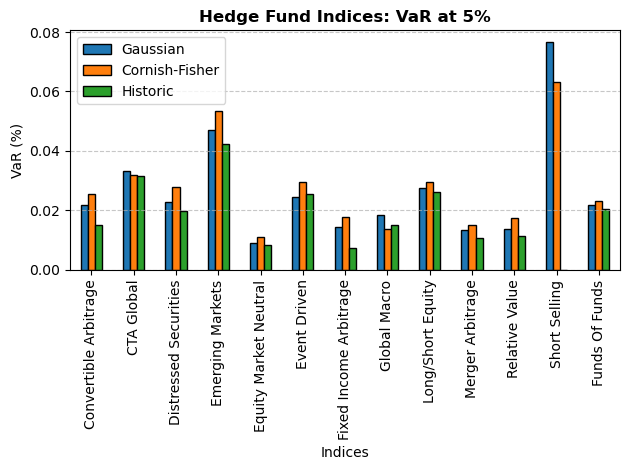

In [176]:
var_table = [
    var_gaussian(hfi), 
    var_gaussian(hfi, modified=True), 
    var_historic(hfi)
]

comparison = pd.concat(var_table, axis=1)
comparison.columns = ['Gaussian', 'Cornish-Fisher', 'Historic']

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
comparison.plot.bar(
    title="Hedge Fund Indices: VaR at 5%",
    color=['#1f77b4', '#ff7f0e', '#2ca02c'],  # Custom colors
    edgecolor='black'  # Add edgecolor for distinction
)

plt.title("Hedge Fund Indices: VaR at 5%", fontweight='bold')
plt.ylabel("VaR (%)")
plt.xlabel("Indices")
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal gridlines for readability

plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
plt.show()


# Efficient Frontier Analysis

In this section, we explore the Efficient Frontier, a concept from modern portfolio theory that outlines the set of optimal portfolios offering the highest expected return for a given risk level or the lowest risk for a set return. It's based on the diversification principle, showing how different asset combinations can minimize overall portfolio risk. We'll cover calculating expected returns and variances, and use optimization techniques to identify these optimal portfolios. This analysis aids in asset allocation decisions, aiming to maximize returns while controlling risk.

The dataset for this section encompasses monthly returns for 30 industry portfolios spanning from July 1926 to February 2024. The construction of these portfolios involved categorizing each NYSE, AMEX, and NASDAQ stock into an industry based on its SIC code as of June each year. The data comes from Kenneth R. French website.

In [29]:
def load_industry_returns():
    """
    Loads the Ken French 30 Industry Portfolios dataset, containing value-weighted monthly returns.
    The function reads the CSV file, formats the data by adjusting the returns scale, sets the datetime index,
    and cleans up the column names for easier access.
    """
    # Read the dataset, adjust the returns scale, and set the index
    industry_data = pd.read_csv("data/30_Industry_Portfolios.csv", header=0, index_col=0) / 100
    industry_data.index = pd.to_datetime(industry_data.index, format="%Y%m").to_period('M')
    # Clean column names
    industry_data.columns = industry_data.columns.str.strip()
    
    return industry_data

In [30]:
ind = load_industry_returns()
ind.shape

(1172, 30)

In [42]:
def annualize_rets(r, periods_per_year):
    """
    Converts a series of periodic returns to annualized returns. This function computes
    the compounded annual growth rate based on the returns provided, taking into account
    the frequency of the returns data.

    Parameters:
    - r (pd.Series or pd.DataFrame): Periodic returns.
    - periods_per_year (int): The number of periods in a year (e.g., 12 for monthly data, 252 for daily data).

    Returns:
    - Annualized returns (float or pd.Series): The rate of return per year.
    """
    compounded_growth = (1 + r).prod()
    n_periods = r.shape[0]
    annualized_return = compounded_growth ** (periods_per_year / n_periods) - 1
    return annualized_return

In [186]:
def annualize_vol(r, periods_per_year):
    """
    Converts the volatility of periodic returns to annualized volatility. This function calculates
    the standard deviation of the provided returns and scales it to an annual basis by accounting
    for the number of periods per year.

    Parameters:
    - r (pd.Series or pd.DataFrame): Periodic returns.
    - periods_per_year (int): Number of periods in a year (e.g., 12 for monthly, 252 for daily).

    Returns:
    - Annualized volatility (float or pd.Series): The standard deviation of returns scaled to one year.
    """
    annualized_volatility = r.std() * (periods_per_year ** 0.5)
    return annualized_volatility

In [187]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Calculates the annualized Sharpe ratio for a series of returns. The Sharpe ratio is a measure
    for calculating risk-adjusted return, and this function annualizes that figure by taking into
    account the risk-free rate and the number of periods per year.

    Parameters:
    - r (pd.Series or pd.DataFrame): Periodic returns.
    - riskfree_rate (float): The annual risk-free rate as a decimal.
    - periods_per_year (int): Number of periods in a year (e.g., 12 for monthly, 252 for daily).

    Returns:
    - Annualized Sharpe ratio (float): The risk-adjusted return scaled to one year.
    """
    # Convert the annual risk-free rate to the equivalent periodic rate
    rf_per_period = (1 + riskfree_rate) ** (1 / periods_per_year) - 1
    # Calculate excess returns by subtracting the risk-free return from the returns
    excess_ret = r - rf_per_period
    # Annualize the excess returns
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    # Annualize the volatility of the returns
    ann_vol = annualize_vol(r, periods_per_year)
    # Compute the Sharpe ratio as the ratio of annualized excess returns to annualized volatility
    return ann_ex_ret / ann_vol

In [188]:
sharpe_ratio(ind, 0.03, 12).sort_values()

Coal     0.096368
Steel    0.151289
Whlsl    0.170251
Txtls    0.176550
Other    0.183663
Games    0.193267
Mines    0.198723
Books    0.201566
Trans    0.220464
Autos    0.244714
Cnstr    0.267408
Carry    0.277028
Clths    0.278562
Fin      0.283406
Servs    0.286709
FabPr    0.288732
ElcEq    0.291253
Util     0.303067
Hshld    0.311890
Oil      0.326385
Chems    0.333433
Paper    0.339137
Meals    0.344420
Beer     0.354349
Telcm    0.357019
Rtail    0.380431
BusEq    0.381377
Smoke    0.436382
Hlth     0.440611
Food     0.452684
dtype: float64

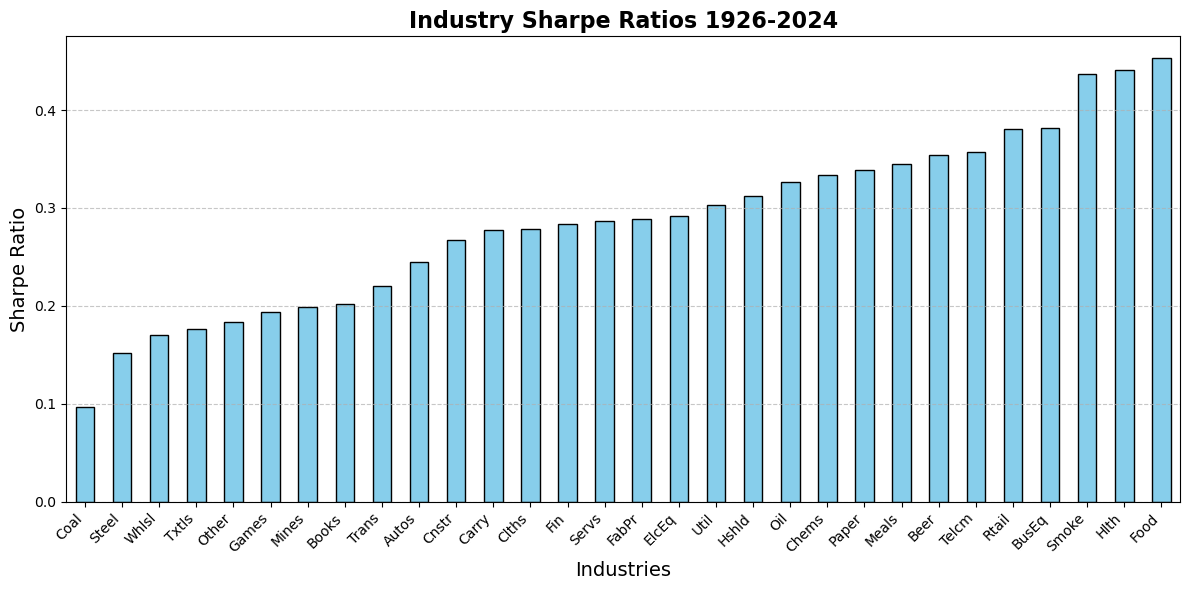

In [193]:
# Assuming 'ind' is your DataFrame of industry returns
sharpe_ratios = sharpe_ratio(ind, 0.03, 12).sort_values()

plt.figure(figsize=(12, 6))  # Set the figure size for better readability
sharpe_ratios.plot.bar(
    color='skyblue', edgecolor='black',  # Add color and edge color to bars
    title="Industry Sharpe Ratios 1926-2024"  # Set title
)

plt.title("Industry Sharpe Ratios 1926-2024", fontsize=16, fontweight='bold')  # Customize title
plt.xlabel("Industries", fontsize=14)  # Customize x-axis label
plt.ylabel("Sharpe Ratio", fontsize=14)  # Customize y-axis label
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal gridlines for readability

plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()  # Display the plot

### Estimating Expected Returns and Covariance for the Efficient Frontier
To generate the efficient frontier, we estimate expected returns and a covariance matrix from historical data, acknowledging this naive approach has limitations, which we'll explore later.

In [195]:
er = annualize_rets(ind["2000":"2005"], 12)
cov = ind["2000":"2005"].cov()

In [196]:
def calculate_portfolio_return(weights, returns):
    """
    Calculates the total return of a portfolio based on the individual asset returns and their respective weights.
    Both weights and returns should be provided as numpy arrays or Nx1 matrices.

    Parameters:
    - weights (numpy array or Nx1 matrix): The allocation weights for each asset in the portfolio.
    - returns (numpy array or Nx1 matrix): The returns for each asset in the portfolio.

    Returns:
    - The total return of the portfolio as a scalar value.
    """
    return np.dot(weights.T, returns)

In [197]:
def calculate_portfolio_volatility(weights, covmat):
    """
    Calculates the volatility of a portfolio given its weights and the covariance matrix of its assets.
    The weights should be provided as a numpy array or an N x 1 matrix, and the covariance matrix should
    be an N x N matrix, where N is the number of assets in the portfolio.

    Parameters:
    - weights (numpy array or N x 1 matrix): The allocation weights of the assets in the portfolio.
    - covmat (N x N matrix): The covariance matrix of the asset returns.

    Returns:
    - float: The overall portfolio volatility as a scalar value.
    """
    return np.sqrt(np.dot(weights.T, np.dot(covmat, weights)))

In [198]:
l = ["Food", "Beer", "Smoke", "Coal"]

In [200]:
ew = np.repeat(0.25, 4)
calculate_portfolio_return(ew, er[l])

0.1985185598936859

In [201]:
calculate_portfolio_volatility(ew, cov.loc[l,l])

0.05424874435919324

To determine the optimal asset weights that achieve a specific target return with minimal volatility, we employ an optimization function. This function utilizes the set of expected returns and the covariance matrix to calculate the weights that both meet the target return and minimize portfolio volatility.

Utilizing this function allows for the efficient creation of an optimal portfolio, balancing the desired return with minimized risk. Following this, we can proceed to plot the efficient frontier, illustrating the trade-off between risk and return for various portfolio compositions.

In [207]:
def minimize_vol(target_return, er, cov):
    """
    Finds the optimal portfolio weights that achieve a specified target return
    with the lowest possible volatility, based on expected returns and the covariance matrix.

    Parameters:
    - target_return (float): The desired target return for the portfolio.
    - er (numpy array): An array of expected returns for each asset.
    - cov (numpy array): The covariance matrix of the returns.

    Returns:
    - numpy array: The optimal weights for achieving the target return with minimal volatility.
    """
    n = er.shape[0]  # Number of assets
    init_guess = np.repeat(1/n, n)  # Initial guess for weights
    bounds = ((0.0, 1.0),) * n  # Each weight should be between 0 and 1
    # Constraints: weights sum to 1, and the portfolio return equals the target return
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Weights sum to 1
        {'type': 'eq', 'args': (er,), 'fun': lambda weights, er: target_return - calculate_portfolio_return(weights, er)}  # Target return
    ]
    result = minimize(
        calculate_portfolio_volatility, init_guess, args=(cov,), method='SLSQP',
        options={'disp': False}, constraints=constraints, bounds=bounds
    )
    return result.x


In [209]:
weights_15 = minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15 = calculate_portfolio_volatility(weights_15, cov.loc[l,l])
vol_15

0.041748053177467596

In [215]:
def calculate_optimal_weights(n_points, er, cov):
    """
    Generates a list of optimal portfolio weights by targeting a range of returns.
    This function calculates the optimal weights for a set number of portfolios
    evenly spaced across the achievable return spectrum defined by the minimum
    and maximum expected returns of the assets.

    Parameters:
    - n_points (int): The number of target return points to generate optimal weights for.
    - er (numpy array): An array of expected returns for each asset.
    - cov (numpy array): The covariance matrix of the asset returns.

    Returns:
    - list of numpy arrays: A list containing the optimal asset weights for each target return.
    """
    target_returns = np.linspace(er.min(), er.max(), n_points)
    optimal_weights = [minimize_vol(target_return, er, cov) for target_return in target_returns]
    return optimal_weights

In [233]:
def visualize_efficient_frontier(n_points, er, cov):
    """
    Creates a plot representing the efficient frontier for a given set of assets. 
    This visualization showcases the trade-off between the portfolio's return and volatility,
    highlighting the range of optimal portfolio choices available.

    Parameters:
    - n_points (int): Number of points to calculate along the efficient frontier, defining the granularity.
    - er (numpy array): Expected returns of the assets.
    - cov (numpy array): Covariance matrix of the asset returns.

    Returns:
    - A plot of the efficient frontier, with portfolio volatility on the x-axis and expected returns on the y-axis.
    """
    weights = calculate_optimal_weights(n_points, er, cov)
    returns = [calculate_portfolio_return(w, er) for w in weights]
    volatilities = [calculate_portfolio_volatility(w, cov) for w in weights]
    ef_data = pd.DataFrame({
        "Returns": returns, 
        "Volatility": volatilities
    })
    
    plt.figure(figsize=(10, 6))
    plt.plot(ef_data["Volatility"], ef_data["Returns"], linestyle='-', marker='.', color='blue')
    plt.title("Efficient Frontier", fontsize=14)
    plt.xlabel("Portfolio Volatility", fontsize=12)
    plt.ylabel("Portfolio Return", fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    #plt.show()

    return plt.show()


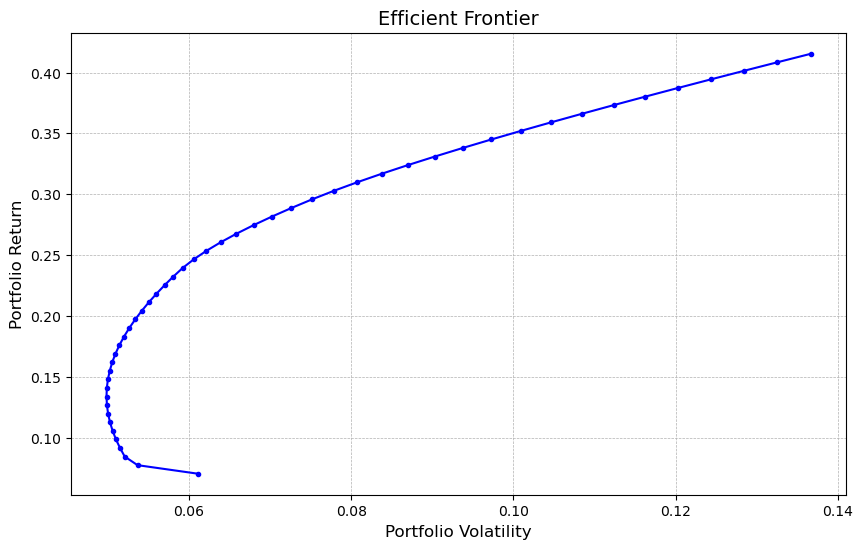

In [234]:
l = ["Smoke", "Fin", "Games", "Coal"]
visualize_efficient_frontier(50, er[l], cov.loc[l,l])

## Identifying the Maximum Sharpe Ratio Portfolio

This section focuses on the method to locate the portfolio with the highest Sharpe ratio, known as the Max Sharpe Ratio Portfolio. The Sharpe ratio measures risk-adjusted returns, indicating how much excess return is received for the extra volatility endured by holding a riskier asset. Finding the portfolio with the maximum Sharpe ratio is crucial as it signifies the most efficient allocation of resources, offering the highest return per unit of risk. We will employ optimization techniques to sift through potential portfolios, pinpointing the one that optimizes this ratio.

In [223]:
ind = load_industry_returns()
er = annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

In [229]:
def find_max_sharpe_ratio_portfolio(riskfree_rate, er, cov):
    """
    Calculates the portfolio weights that maximize the Sharpe ratio.
    
    The Sharpe ratio is a measure of the excess return (over the risk-free rate) 
    per unit of volatility or risk. Maximizing this ratio helps to identify the 
    portfolio that provides the best possible risk-adjusted return.

    Parameters:
    - riskfree_rate (float): The risk-free rate of return.
    - er (numpy array): Expected returns for each asset.
    - cov (numpy array): Covariance matrix for the asset returns.

    Returns:
    - numpy array: The weights of the portfolio that maximizes the Sharpe ratio.
    """
    n_assets = er.shape[0]
    initial_guess = np.repeat(1 / n_assets, n_assets)
    bounds = ((0.0, 1.0),) * n_assets  # Ensures weights are between 0 and 1 for each asset.

    # Constraint to ensure the sum of the weights equals 1.
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

    # Objective function: Negative Sharpe ratio (to be minimized).
    def negative_sharpe_ratio(weights, riskfree_rate, er, cov):
        portfolio_returns = calculate_portfolio_return(weights, er)
        portfolio_volatility = calculate_portfolio_volatility(weights, cov)
        sharpe_ratio = (portfolio_returns - riskfree_rate) / portfolio_volatility
        return -sharpe_ratio  # Negative for minimization.

    # Optimization process to find the portfolio that minimizes the negative Sharpe ratio.
    optimal_weights = minimize(negative_sharpe_ratio, initial_guess,
                               args=(riskfree_rate, er, cov), method='SLSQP',
                               options={'disp': False},
                               constraints=constraints,
                               bounds=bounds)
    return optimal_weights.x


In [236]:
def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0):
    """
    Creates an enhanced visual representation of the multi-asset efficient frontier.
    Optionally, it can also display the Capital Market Line (CML) to illustrate the risk-free asset's integration.

    Parameters:
    - n_points (int): Number of points on the efficient frontier.
    - er (pd.Series): Expected returns for each asset.
    - cov (pd.DataFrame): Covariance matrix of the asset returns.
    - style (str): Plot style for the efficient frontier.
    - legend (bool): If True, displays a legend.
    - show_cml (bool): If True, plots the CML.
    - riskfree_rate (float): Risk-free rate used in CML calculation.
    """
    weights = calculate_optimal_weights(n_points, er, cov)
    rets = [calculate_portfolio_return(w, er) for w in weights]
    vols = [calculate_portfolio_volatility(w, cov) for w in weights]
    ef = pd.DataFrame({"Returns": rets, "Volatility": vols})
    
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend, figsize=(10, 6))
    ax.set_title('Efficient Frontier with Optional CML', fontsize=16)
    ax.set_xlabel('Volatility', fontsize=14)
    ax.set_ylabel('Expected Returns', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    if show_cml:
        ax.set_xlim(left=0)
        w_msr = find_max_sharpe_ratio_portfolio(riskfree_rate, er, cov)
        r_msr = calculate_portfolio_return(w_msr, er)
        vol_msr = calculate_portfolio_volatility(w_msr, cov)
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12, label='Capital Market Line')
        if legend:
            ax.legend(frameon=True, framealpha=0.8, fancybox=True)

    return ax


<Axes: title={'center': 'Efficient Frontier with Optional CML'}, xlabel='Volatility', ylabel='Expected Returns'>

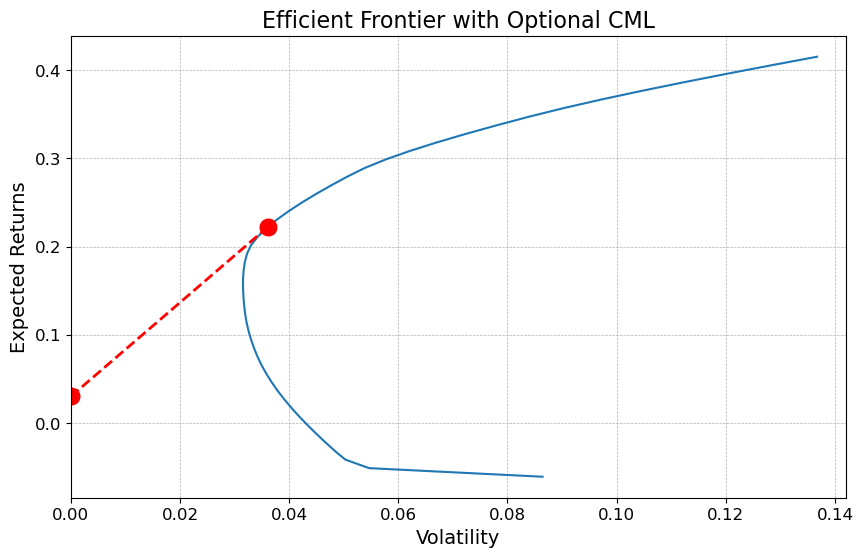

In [238]:
plot_ef(50, er, cov, style='-', show_cml=True, riskfree_rate=0.03)

## Equally Weighted, and GMV Portfolios

The Markowitz optimization procedure offers a theoretical framework for maximizing portfolio returns for a given level of risk. However, its practical application faces challenges due to the sensitivity to estimation errors in expected returns and covariances. Such inaccuracies can significantly impact the optimal portfolio composition, often leading to exaggerated allocations. In contrast, the Equally Weighted Portfolio, distributing capital evenly across assets, and the Global Minimum Variance (GMV) Portfolio, focusing solely on minimizing volatility, provide alternative strategies. These approaches aim to mitigate the impact of estimation errors by simplifying portfolio construction without the need for precise return forecasts, showcasing their relevance in dealing with the inherent uncertainties of financial markets. As we proceed, we will explore the comparative robustness and implications of these strategies through data analysis.

In [240]:
def calculate_gmv_weights(cov):
    """
    Calculates the weights for the Global Minimum Variance (GMV) portfolio. 
    The GMV portfolio is designed to minimize the overall portfolio volatility 
    based on the given covariance matrix of asset returns.

    Parameters:
    - cov (numpy array): Covariance matrix of the asset returns.

    Returns:
    - numpy array: Optimal portfolio weights for the GMV portfolio.
    """
    n_assets = cov.shape[0]
    # Utilizes the Maximum Sharpe Ratio function with a risk-free rate of 0 
    # and equal expected returns to find the minimum variance portfolio
    gmv_weights = find_max_sharpe_ratio_portfolio(0, np.ones(n_assets), cov)
    return gmv_weights

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_ef(n_points, er, cov, style='.-', legend=True, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    """
    Enhanced visualization of the efficient frontier with options to display the Capital Market Line (CML),
    Equal Weight (EW) portfolio, and Global Minimum Volatility (GMV) portfolio. This version introduces
    aesthetic improvements for a clearer and more engaging presentation.
    """
    weights = calculate_optimal_weights(n_points, er, cov)
    rets = [calculate_portfolio_return(w, er) for w in weights]
    vols = [calculate_portfolio_volatility(w, cov) for w in weights]
    ef = pd.DataFrame({"Returns": rets, "Volatility": vols})
    
    plt.figure(figsize=(10, 6))
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend, color='darkslateblue')
    ax.set_facecolor('whitesmoke')  # Light background color for the plot area
    plt.title('Efficient Frontier', fontsize=16, fontweight='bold')
    plt.xlabel('Volatility', fontsize=14)
    plt.ylabel('Expected Returns', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    
    # Adding the Capital Market Line
    if show_cml:
        w_msr = find_max_sharpe_ratio_portfolio(riskfree_rate, er, cov)
        r_msr = calculate_portfolio_return(w_msr, er)
        vol_msr = calculate_portfolio_volatility(w_msr, cov)
        cml_label = f'CML (Risk-Free Rate: {riskfree_rate*100:.2f}%)'
        ax.plot([0, vol_msr], [riskfree_rate, r_msr], 'g--', marker='o', markersize=8, color='crimson', linewidth=2, label=cml_label)
    
    # Plotting Equal Weight Portfolio
    if show_ew:
        w_ew = np.repeat(1/er.shape[0], er.shape[0])
        r_ew = calculate_portfolio_return(w_ew, er)
        vol_ew = calculate_portfolio_volatility(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color='gold', marker='*', markersize=14, label='EW Portfolio')
    
    # Plotting Global Minimum Volatility Portfolio
    if show_gmv:
        w_gmv = calculate_gmv_weights(cov)
        r_gmv = calculate_portfolio_return(w_gmv, er)
        vol_gmv = calculate_portfolio_volatility(w_gmv, cov)
        ax.plot([vol_gmv], [r_gmv], color='navy', marker='*', markersize=14, label='GMV Portfolio')
    
    # Enhancing the legend
    if legend:
        ax.legend(frameon=True, framealpha=0.9, shadow=True, fancybox=True, loc='best')
    
    plt.show()
    return ax


/var/folders/g8/p_3zs4gn64vc1d40qp2p3s700000gp/T/ipykernel_61517/2538800955.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g--" (-> color='g'). The keyword argument will take precedence.
  ax.plot([0, vol_msr], [riskfree_rate, r_msr], 'g--', marker='o', markersize=8, color='crimson', linewidth=2, label=cml_label)


<Figure size 1000x600 with 0 Axes>

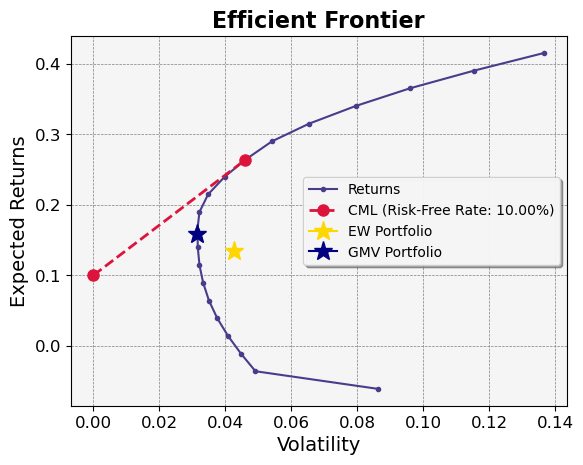

<Axes: title={'center': 'Efficient Frontier'}, xlabel='Volatility', ylabel='Expected Returns'>

In [244]:
plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True, show_gmv=True)

### Exploring the Limits of Diversification

Diversification is a fundamental investment strategy aimed at reducing risk by spreading investments across various assets. However, its effectiveness can be limited during market crashes. During these periods, asset correlations tend to increase, meaning that the assets that typically move independently may start moving in the same direction, thus diminishing the benefits of diversification. In this section, we will analyze how asset correlations behave during market downturns.

### Implementing a Cap-Weighted Portfolio

This section constructs a cap-weighted index using 30 industry portfolios, where each industry is weighted by its total market capitalization—calculated by multiplying the average market cap of companies within the industry by the number of companies in that industry. This approach mirrors the method used in most market indices.

This code defines functions to load and format industry portfolio data related to the average number of firms and market capitalization size from CSV files. It employs a general helper function to handle the repetitive tasks of reading the CSV, setting the datetime index, and cleaning up column names. Finally, it uses these functions to load the data into Pandas DataFrames for further analysis.

In [3]:
def load_and_format_industry_data(file_path):
    """
    Loads and formats the Ken French 30 Industry Portfolios data from a CSV file.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: A DataFrame with the formatted industry data.
    """
    data = pd.read_csv(file_path, header=0, index_col=0)
    data.index = pd.to_datetime(data.index, format="%Y%m").to_period('M')
    data.columns = data.columns.str.strip()
    return data

def get_ind_nfirms():
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms.
    """
    return load_and_format_industry_data("data/30_Industry_Portfolios_n_firms.csv")

def get_ind_size():
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap).
    """
    return load_and_format_industry_data("data/30_Industry_Portfolios_size.csv")

# Load data using the defined functions
ind_nfirms = get_ind_nfirms()
ind_size = get_ind_size()


In [7]:
ind_mktcap = ind_nfirms * ind_size

In [8]:
total_mktcap = ind_mktcap.sum(axis=1)

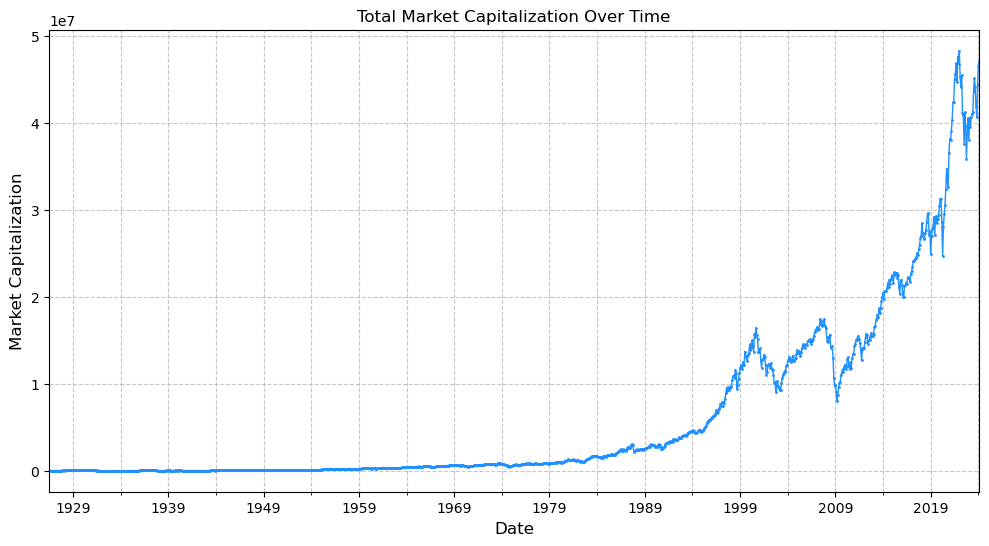

In [17]:
# Assuming 'total_mktcap' is a pandas Series or DataFrame
total_mktcap.plot(
    figsize=(12, 6), 
    color='dodgerblue',  # Use a visually appealing color
    linestyle='-',  # Solid line
    linewidth=1,  # Thicker line for better visibility
    marker='o',  # Mark data points
    markersize=1,  # Slightly larger marker size for visibility
    title='Total Market Capitalization Over Time'  # Title of the plot
)

plt.xlabel('Date', fontsize=12)  # Customize the x-axis label
plt.ylabel('Market Capitalization', fontsize=12)  # Customize the y-axis label
plt.grid(True, which='both', linestyle='--', alpha=0.7)  # Enable grid for easier reading
plt.show()  # Show the plot


In [18]:
ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")

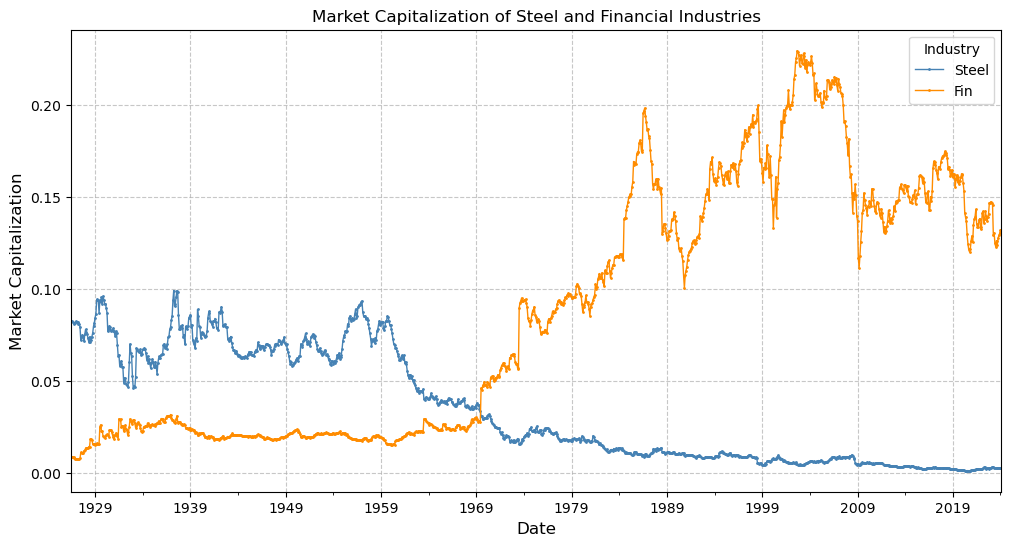

In [24]:
# Assuming 'ind_capweight' is a pandas DataFrame containing the industries data
ax = ind_capweight[["Steel", "Fin"]].plot(
    figsize=(12, 6),
    color=['steelblue', 'darkorange'],  # Assign different colors to each industry for distinction
    linestyle='-',  # Use solid lines for clarity
    linewidth=1,  # Use thicker lines for better visibility
    marker='o',  # Mark each data point for better tracing
    markersize=1,  # Set a moderate marker size for visibility without clutter
    title='Market Capitalization of Steel and Financial Industries'  # Title of the plot
)

ax.set_xlabel('Date', fontsize=12)  # Label the x-axis
ax.set_ylabel('Market Capitalization', fontsize=12)  # Label the y-axis
ax.grid(True, linestyle='--', alpha=0.7)  # Enable grid for easier data interpretation
ax.legend(title='Industry')  # Add a legend with a title

plt.show()  # Display the plot

In [31]:
def get_total_market_index_returns():
    """
    Calculates the returns of a cap-weighted total market index using the 30 industry portfolios.
    This function loads data for the number of firms and their sizes across different industries,
    computes the market capitalization for each industry, and then derives the weighted returns
    based on these market capitalizations.

    Returns:
    - pd.Series: The total market index returns, indexed by date.
    """
    # Load data for number of firms, their sizes, and returns from the industry portfolios
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_return = load_industry_returns()
    
    # Calculate total market capitalization for each industry
    ind_mktcap = ind_nfirms * ind_size
    
    # Sum market capitalizations across all industries to get total market cap at each time point
    total_mktcap = ind_mktcap.sum(axis=1)
    
    # Calculate the capital weights for each industry
    ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
    
    # Compute the total market return by summing the product of industry returns and their weights
    total_market_return = (ind_capweight * ind_return).sum(axis="columns")
    
    return total_market_return

In [37]:
total_market_return = get_total_market_index_returns()
total_market_index = calculate_drawdown(total_market_return).Wealth

In [ ]:
# Assuming 'total_mktcap' is a pandas Series or DataFrame
total_mktcap.plot(
    figsize=(12, 6), 
    color='dodgerblue',  # Use a visually appealing color
    linestyle='-',  # Solid line
    linewidth=1,  # Thicker line for better visibility
    marker='o',  # Mark data points
    markersize=1,  # Slightly larger marker size for visibility
    title='Total Market Capitalization Over Time'  # Title of the plot
)

plt.xlabel('Date', fontsize=12)  # Customize the x-axis label
plt.ylabel('Market Capitalization', fontsize=12)  # Customize the y-axis label
plt.grid(True, which='both', linestyle='--', alpha=0.7)  # Enable grid for easier reading
plt.show()  # Show the plot


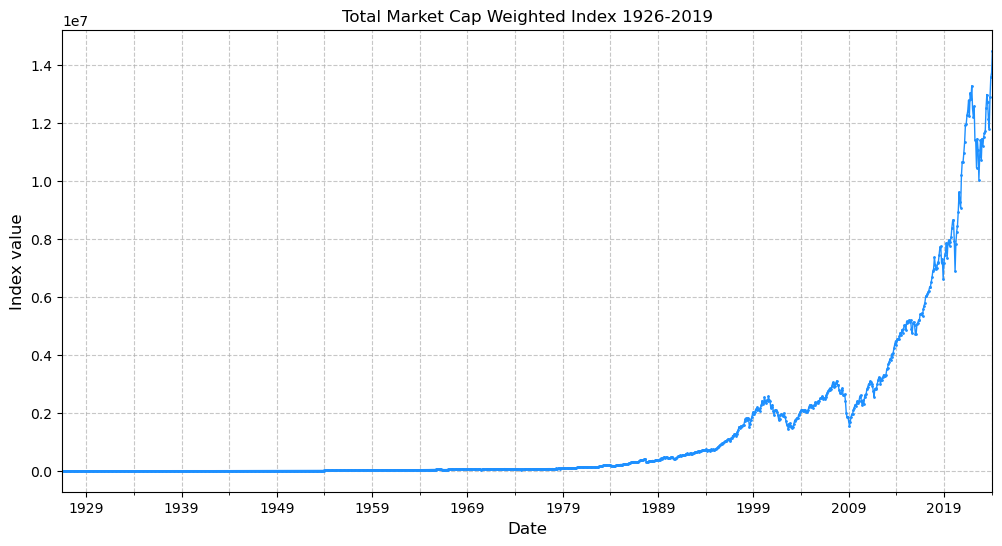

In [38]:
total_market_index.plot(
    figsize=(12, 6), 
    color='dodgerblue',  # Use a visually appealing color
    linestyle='-',  # Solid line
    linewidth=1,  # Thicker line for better visibility
    marker='o',  # Mark data points
    markersize=1,  # Slightly larger marker size for visibility
    title="Total Market Cap Weighted Index 1926-2019"
)

plt.xlabel('Date', fontsize=12)  # Customize the x-axis label
plt.ylabel('Index value', fontsize=12)  # Customize the y-axis label
plt.grid(True, which='both', linestyle='--', alpha=0.7)  # Enable grid for easier reading
plt.show()  # Show the plot

# Rolling Windows

Using Pandas' rolling window functionality, we'll calculate the average return over a trailing 36-month period for a series of returns.

<Axes: >

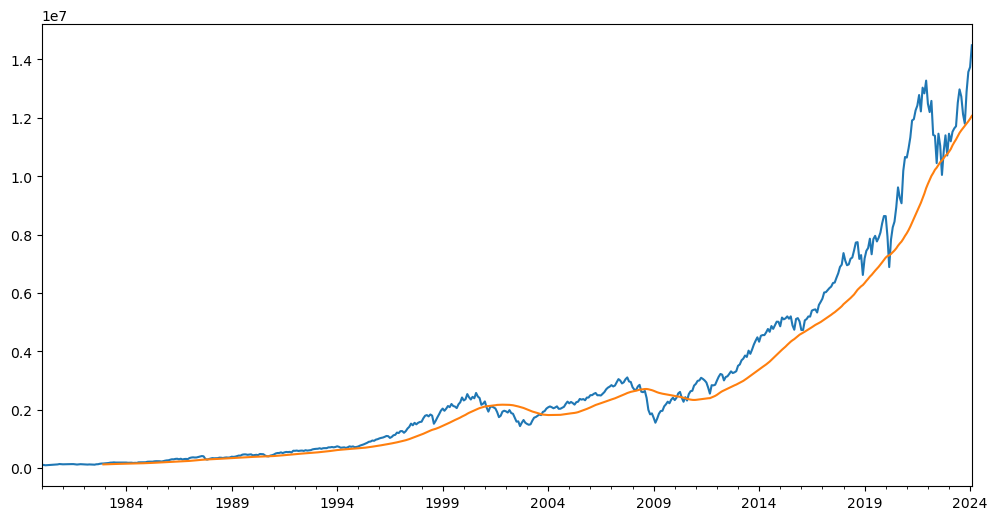

In [39]:
total_market_index["1980":].plot(figsize=(12, 6))
total_market_index["1980":].rolling(window=36).mean().plot()

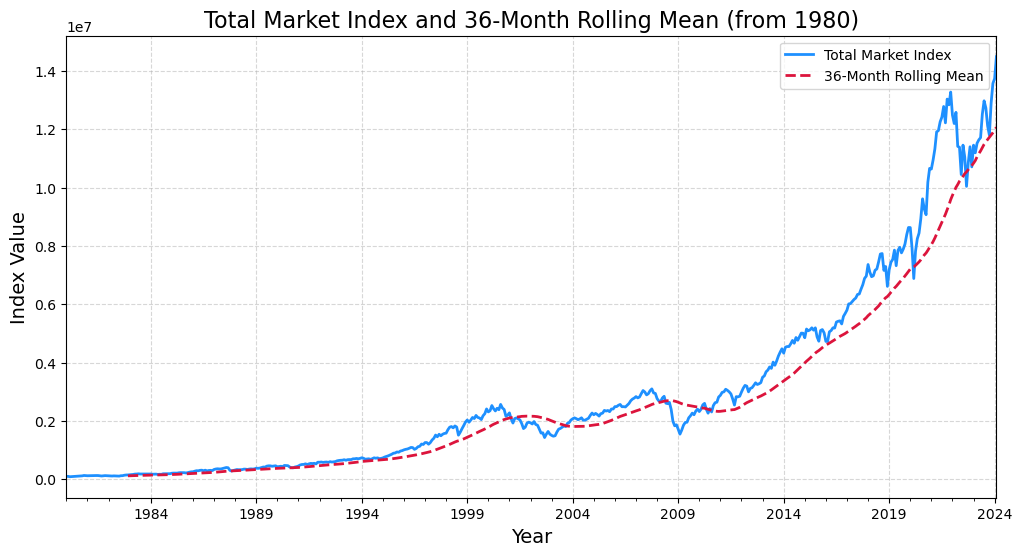

In [40]:
# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the total market index data from 1980 onwards
total_market_index["1980":].plot(ax=ax, color='dodgerblue', label='Total Market Index', linewidth=2)

# Plot the rolling mean of the total market index over a 36-month window
total_market_index["1980":].rolling(window=36).mean().plot(ax=ax, color='crimson', label='36-Month Rolling Mean', linewidth=2, linestyle='--')

# Add a title and labels
ax.set_title('Total Market Index and 36-Month Rolling Mean (from 1980)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Index Value', fontsize=14)

# Add a grid for better readability of the plot
ax.grid(True, linestyle='--', alpha=0.5)

# Add a legend to distinguish between lines
ax.legend()

# Show the plot
plt.show()


<Axes: >

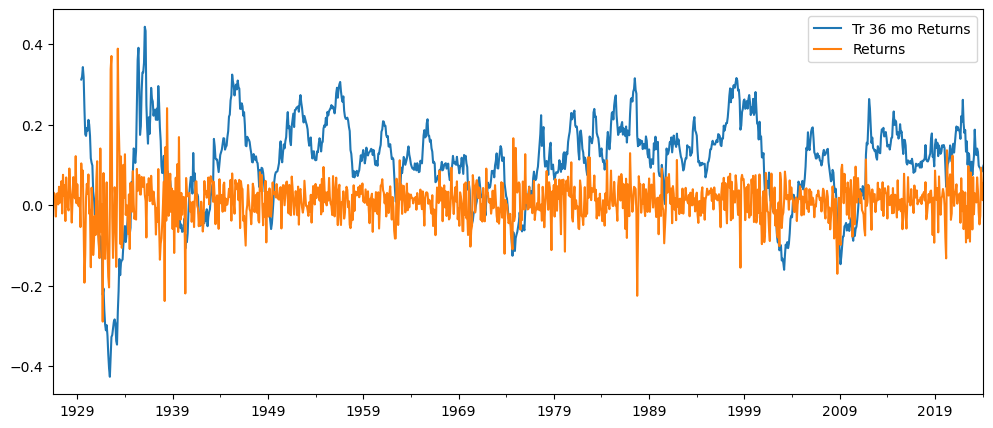

In [43]:
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(annualize_rets, periods_per_year=12)
tmi_tr36rets.plot(figsize=(12,5), label="Tr 36 mo Returns", legend=True)
total_market_return.plot(label="Returns", legend=True)

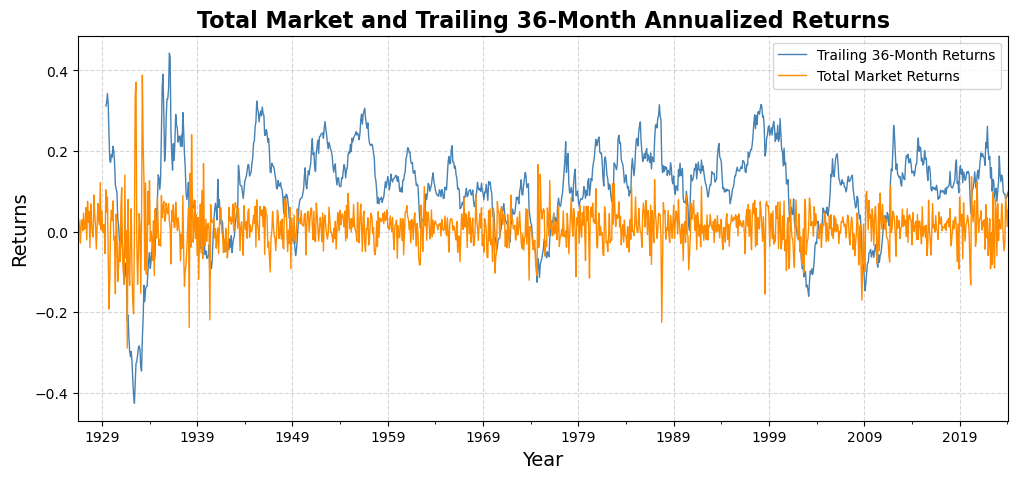

In [46]:
# Assuming total_market_return is defined and annualize_rets function is available
tmi_tr36rets = total_market_return.rolling(window=36).aggregate(annualize_rets, periods_per_year=12)

# Create a figure and axis object with Matplotlib
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the 36-month trailing returns on the created axis
tmi_tr36rets.plot(ax=ax, color='steelblue', label="Trailing 36-Month Returns", linewidth=1, legend=True)

# Plot the original total market returns on the same axis
total_market_return.plot(ax=ax, color='darkorange', label="Total Market Returns", linewidth=1, legend=True)

# Set title and labels with improved font sizes for better readability
ax.set_title('Total Market and Trailing 36-Month Annualized Returns', fontsize=16, fontweight='bold')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Returns', fontsize=14)

# Add a grid for easier analysis
ax.grid(True, linestyle='--', alpha=0.5)

# Add a legend with a slightly transparent background for better visibility of data
ax.legend(fancybox=True, framealpha=0.8)

# Display the plot
plt.show()


In this part, we analyze time-series correlations between industry returns over rolling 36-month windows. The code calculates the rolling correlation for each industry, sets appropriate index names for clarity, and then computes the average correlation for each time period across all industries. This provides insight into how industry correlations evolve over time, particularly focusing on changes during different market conditions.

In [48]:
ind_return = load_industry_returns()
ts_corr = ind_return.rolling(window=36).corr()
ts_corr.index.names = ['date', 'industry']
ind_tr36corr = ts_corr.groupby(level='date').apply(lambda cormat: cormat.values.mean())

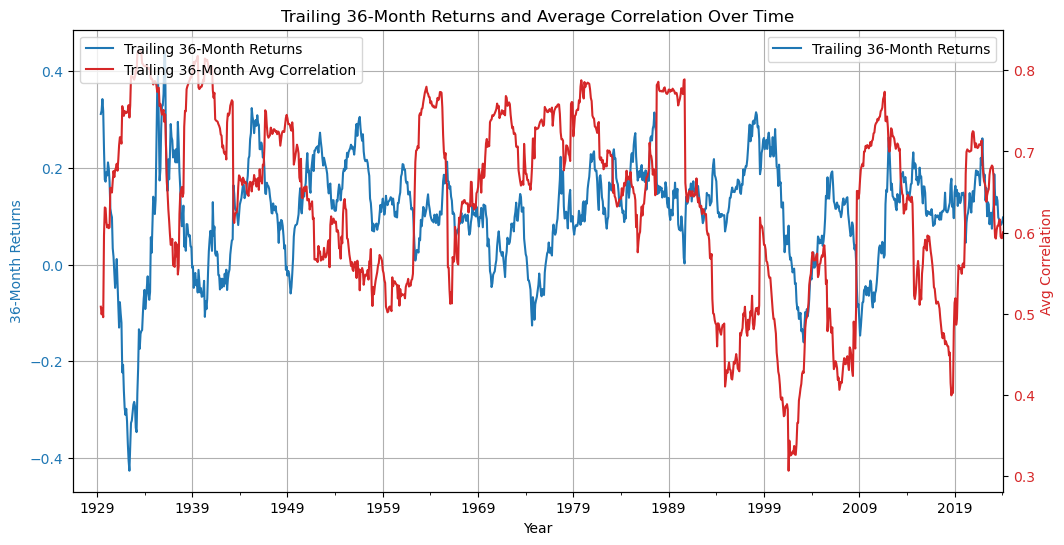

In [52]:
# Create a single figure and two different axes objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the trailing 36-month returns on the primary y-axis
color = 'tab:blue'  # Define a color for the first plot
tmi_tr36rets.plot(ax=ax1, color=color, label="Trailing 36-Month Returns", legend=True)
ax1.set_xlabel('Year')  # Label for the x-axis
ax1.set_ylabel('36-Month Returns', color=color)  # Label the primary y-axis and match the color
ax1.tick_params(axis='y', labelcolor=color)  # Ensure the tick labels match the line color
ax1.grid(True)  # Add grid lines for better readability

# Plot the trailing 36-month average correlation on a secondary y-axis
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'  # Define a color for the second plot
ind_tr36corr.plot(ax=ax2, color=color, label="Trailing 36-Month Avg Correlation", legend=True)
ax2.set_ylabel('Avg Correlation', color=color)  # Label the secondary y-axis and match the color
ax2.tick_params(axis='y', labelcolor=color)  # Ensure the tick labels match the line color

# Add a title to the plot
plt.title('Trailing 36-Month Returns and Average Correlation Over Time')

# Create a unified legend for both lines
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')  # Positioning the legend

# Show the plot
plt.show()
